In [1]:
%matplotlib inline

In [2]:
%precision 3

'%.3f'

In [5]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.stats as sms
from statsmodels.tsa import vector_ar, descriptivestats
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

import matplotlib.pyplot as plt

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
sns.set(style='ticks', palette='Set2')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Caso 2.3 (PRESENTAR)
Estudio de las __relaciones__ entre los __PIB__ de varios países entre sí. Identificación de países dominantes y países seguidores.

En este ejercicio se trata de estimar un __modelo multiecuacional__ en el que se analizan las relaciones entre el __crecimiento del PIB__ de tres países cualquiera extraídos de alguna base de datos (Ministerio de Economía, Banco de España, INE, etc.). 

Una vez tengamos los datos __(preferiblemente trimestrales)__ del PIB a __precios constantes__, tendremos que calcular la __tasa de crecimiento anual__ para cada país y luego estimaremos un __modelo VAR sin restricciones__, Se trata de ver si algún país de los seleccionados actúa como líder y si el resto de países actúan como seguidores.

## DATOS
- Nombre: Chain GDP (millons euros)
- Fuente: EUROSTAT
- Enlace: http://ec.europa.eu/eurostat/web/national-accounts/data/database

In [7]:
data = pd.read_csv('eu_gdp_q.csv', index_col=0)

In [8]:
for i,e in enumerate(data.GEO.unique()):
    print(i,e)

0 European Union (28 countries)
1 European Union (15 countries)
2 Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
3 Euro area (19 countries)
4 Euro area (18 countries)
5 Euro area (12 countries)
6 Belgium
7 Bulgaria
8 Czech Republic
9 Denmark
10 Germany (until 1990 former territory of the FRG)
11 Estonia
12 Ireland
13 Greece
14 Spain
15 France
16 Croatia
17 Italy
18 Cyprus
19 Latvia
20 Lithuania
21 Luxembourg
22 Hungary
23 Malta
24 Netherlands
25 Austria
26 Poland
27 Portugal
28 Romania
29 Slovenia
30 Slovakia
31 Finland
32 Sweden
33 United Kingdom
34 Iceland
35 Norway
36 Switzerland
37 Former Yugoslav Republic of Macedonia, the
38 Albania
39 Serbia


In [9]:
index_paises = [10, 14, 33]

In [10]:
paises = data.GEO.unique()[index_paises]

In [11]:
d = dict()
for p in paises:
    d[p] = data[data.GEO == p].Value

In [12]:
pib = pd.DataFrame.from_dict(d)

In [13]:
pib.columns = ['germany', 'spain', 'uk']

# VALORES PERDIDOS

In [14]:
pib.replace(to_replace=':', value=np.nan, inplace=True)

In [15]:
pib.head()

,germany,spain,uk
TIME,,,
1975Q1,NaN,NaN,206 522.0
1975Q2,NaN,NaN,202 980.6
1975Q3,NaN,NaN,202 336.9
1975Q4,NaN,NaN,204 823.2
1976Q1,NaN,NaN,208 175.8


In [16]:
pib = pib.dropna()
pib = pib.applymap(lambda x: x.replace(' ', ''))
pib = pib.astype('float')
pib.head()

,germany,spain,uk
TIME,,,
1995Q1,532282.4,175965,327356.5
1995Q2,536668.6,177181,328610.3
1995Q3,538410.2,178027,332094.4
1995Q4,538152.2,179278,333514.5
1996Q1,533089.0,180436,337196.3


In [17]:
len(pib)

83

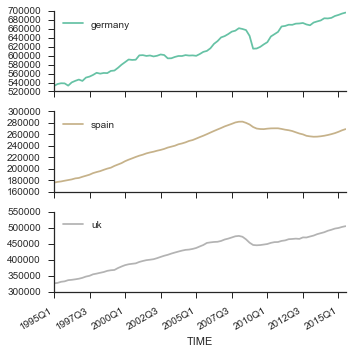

In [48]:
kws_sp = {'subplots':True, 'layout':(3,1), 'figsize':(5,5), 'cmap':'Set2'}
g = pib.plot(**kws_sp)

for ax in g.flatten():
    sns.despine(ax=ax)

plt.tight_layout()

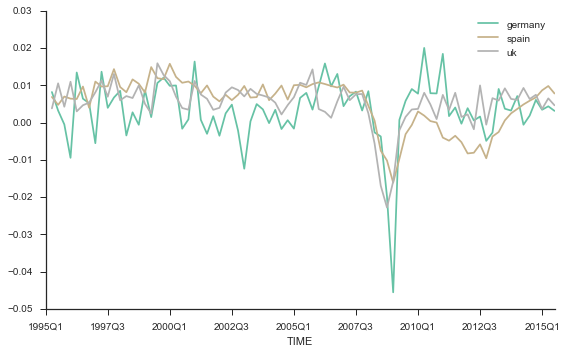

In [49]:
kws = {'figsize':(8,5), 'cmap':'Set2'}

d_pib = pib.apply(np.log).diff()
g = d_pib.plot(**kws)
sns.despine()
plt.tight_layout()

In [54]:
for pais in pib.columns:
    d = d_pib
    print('%s:\t ADF: %s \tpvalue:%s' % (pais.upper(), *adfuller(d[pais], maxlag=16, autolag='sbic', )[:2]))

LinAlgError: SVD did not converge

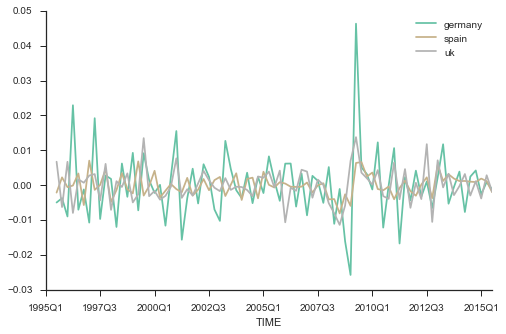

In [45]:
dd_pib = d_pib.diff()
dd_pib.plot(**kws)
sns.despine()

In [36]:
for pais in pib.columns:
    d = d_pib
    print('%s:\t ADF: %s \tpvalue:%s' % (pais.upper(), *adfuller(d[pais], maxlag=14)[:2]))

GERMANY:	 ADF: -0.71186507205 	pvalue:0.843652232618
SPAIN:	 ADF: -1.87838431527 	pvalue:0.342297127287
UK:	 ADF: -1.26970413875 	pvalue:0.642916255509


# a)
Antes de estimar un VAR, tenemos que __seleccionar el número óptimo de retardos del VAR__, para ello hay que ir a la opción __Modelo-Series temporales-Selección del orden del VAR__, donde le indicamos nuestro conjunto de variables endógenas, exógenas (si las hubiera) y el máximo número de retardos del VAR. Acortaremos el periodo de manera que __dejaremos las 4 últimas observaciones para predecir__. 

Tras decirle a Gretl que estime hasta con __un máximo de 12 retardos__, se nos presentará una pantalla resumen de resultados donde se nos muestran para cada orden del VAR los estadísticos AIC, SBIC y Hannan-Quinn, seleccionaremos el número de retardos mayor que cero que __minimice esos criterios__.

Ahora que ya hemos seleccionado el número de retardos, volvemos a estimar el sistema en el menú Modelo-Series temporales-Autorregresión vectorial (VAR), donde tras indicar las opciones adecuadas, se nos mostrarán los resultados de la estimación de cada una de las ecuaciones del sistema, tres en nuestro caso. Analizaremos si existe algún __problema residual__ en alguna ecuación mirando los test de autocorrelación __LM(1), ARCH(1) y normalidad__, analizando además los __gráficos residuales. __

Es posible que encontremos algún problema, por ejemplo, es posible que sea necesario incorporar una __variable ficticia__ que dé cuenta de la __crisis del precio del petróleo__ ocurrida en los años 70; a esta nueva variable la podemos llamar __D74__ y tomará valor 1 durante los cuatro trimestres de 1974 y valor 0 el resto. 

Incorporamos esta nueva variable explicativa a nuestro modelo, le indicamos el periodo de estimación, el número de retardos y para ver si resulta conjuntamente significativa o no debemos ir al menú de contraste de hipótesis del VAR y seleccionar la opción que nos hace un contraste sobre la exogeneidad de las variables. Tras indicarle que queremos analizar la exogeneidad de D74 nos calculará un contraste LR de la razón de verosimilitudes, si el valor del p-valor de este contraste es menor que 0,05, aceptamos que mantenemos dicha variable al nivel de significación del 5%. Comprobar cómo cambian los resultados de las tres ecuaciones estimadas del VAR con esta nueva variable y decidir con base en esos resultados si la mantenemos o no.

# b)
Una vez determinado el modelo más adecuado, realizaremos __predicciones dinámicas__ para cada una de las variables endógenas. Para ello, tras indicarle que deje los últimos 20 valores para representar antes del periodo de predicción. Gretl nos ofrecerá una tabla con los valores reales y predichos, los errores y algunas medidas para evaluar y comparar las predicciones. La mejor __medida para comparar__ suele ser el __“porcentaje de error absoluto medio” (EAPM)__, con el que podemos comparar el error medio que comete cada una de las tres ecuaciones.

# c)
Por último, realizaremos un estudio __“impulso-respuesta”__ con el VAR estimado, esto es, _cómo responden las variables endógenas ante un shock en alguna de ellas_; para ello se __descompone la varianza de los errores__ de predicción de las variables a lo largo de diferentes periodos. Una vez que tenemos modelo VAR con las variables que hayamos seleccionado, iremos a la opción __Gráficos-Respuestas al impulso (todas)__ y nos dibujará los efectos impulso-respuesta para un shock de cada variable sobre las demás.

Algo a tener en cuenta es que cuando se calculan los impulso-respuesta ortogonalizados se “normalizan” respecto de la primera variable que seleccionemos, la cual debe ser la que pensemos ejerce mayor influencia sobre las demás, es decir, tenemos que ordenarlas de mayor a menor exogeneidad según creamos. ¿Qué país produce mayores respuestas de los demás ante un shock inicial?